In [1]:
import os
import sys

import pandas as pd
import numpy as np

import datetime

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import seaborn as sns
import statsmodels.api as sm
import scipy.optimize as optim

from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# set font size
# plt.rcParams['font.size'] = 24
# plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120, 'font.size':10})

%config InlineBackend.figure_format='retina'

In [2]:
data_dir = '/Users/genie/data/covid-19/'

In [3]:
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/genie/data/covid-19/.DS_Store
/Users/genie/data/covid-19/jhu_time_series_covid19_deaths_global_narrow.csv
/Users/genie/data/covid-19/owid-covid-data.csv
/Users/genie/data/covid-19/eiu_democracy_indices.csv
/Users/genie/data/covid-19/jhu_time_series_covid19_confirmed_global_narrow.csv
/Users/genie/data/covid-19/jhu_time_series_covid19_recovered_global_narrow.csv
/Users/genie/data/covid-19/us_daily.csv


In [4]:
%%time

data = pd.read_csv(os.path.join(data_dir,'owid-covid-data.csv'))
data = data[data.iso_code.notnull()][['iso_code', 'location', 'date', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_tests','new_tests',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older','gdp_per_capita']]
data = data.rename(columns={'location':'country_name'})


# Merge recoveries data from JHU dataset
recovered_df = pd.read_csv(os.path.join(data_dir,'jhu_time_series_covid19_recovered_global_narrow.csv'))
recovered_df = recovered_df.rename(columns={'iso_country_code':'iso_code','recovered':'total_recoveries'})
recovered_df = recovered_df.groupby(['iso_code','date'])['total_recoveries'].sum().reset_index()
recovered_df['date'] = pd.to_datetime(recovered_df['date'])
recovered_df['date'] = recovered_df['date'].dt.strftime('%Y-%m-%d')
recovered_df['new_recoveries'] = recovered_df['total_recoveries'] - recovered_df.sort_values(by=['date'], ascending=True)\
.groupby(['iso_code'])['total_recoveries'].shift(1)
data = pd.merge(data, recovered_df, how='left', on=['iso_code','date'])
del recovered_df


# Merge democracy indices data
eiu_demox = pd.read_csv(os.path.join(data_dir,'eiu_democracy_indices.csv'))
eiu_demox = eiu_demox[eiu_demox.year==2019][['iso_code','demox_eiu']]
eiu_demox['iso_code'] = eiu_demox['iso_code'].str.upper()
data = pd.merge(data, eiu_demox, how='left', on=['iso_code'])
del eiu_demox

CPU times: user 4.2 s, sys: 78.6 ms, total: 4.28 s
Wall time: 3.3 s


In [5]:
## FEATURES

data['tests_per_capita'] = data['total_tests']/data['population']
data['tests_per_1000'] = data['total_tests']/(data['population']/1000)
data['cases_per_1000'] = data['total_cases']/(data['population']/1000)
data['tests_per_confirmed_case'] = data['new_tests']/data['new_cases']

data['cpr_daily'] = data['new_cases']/data['new_tests'] * 100
data['cpr_total'] = data['total_cases']/data['total_tests'] * 100
data['share_of_infected_population '] = data['total_cases']/data['population'] * 100

data['cfr_daily'] = data['new_deaths']/data['new_cases'] * 100
data['cfr_total'] = data['total_deaths']/data['total_cases'] * 100
data['deaths_per_1000'] = data['total_deaths']/(data['population']/1000)

data['crr_daily'] = data['new_recoveries']/data['new_cases'] * 100
data['crr_total'] = data['total_recoveries']/data['total_cases'] * 100
data['recoveries_per_1000'] = data['total_recoveries']/(data['population']/1000)
data['recoveries_per_confirmed_case'] = data['new_recoveries']/data['new_cases']


### Calculate days until first case, days until 1000 cases

In [6]:
df = data[(data.iso_code.notnull()) & ~(data.iso_code.isin(['OWID_KOS','OWID_WRL']))].copy()

first_case_data = df[df.total_cases > 0].groupby(['iso_code'])['date'].min().reset_index()
first_case_data = first_case_data.rename(columns={'date':'first_case_date'})
df = pd.merge(df, first_case_data, how='left', on=['iso_code'])

# df['days_since_first_case'] = (pd.to_datetime(df['date'])-pd.to_datetime(df['first_case_date'])).dt.days
df['days_until_first_case'] = (pd.to_datetime(df['first_case_date'])-pd.to_datetime(df['date'].min())).dt.days

cases_1000_data = df[df.total_cases>=1000].groupby(['iso_code'])['date'].min().reset_index()
cases_1000_data = cases_1000_data.rename(columns={'date':'cases_1000_date'})
df = pd.merge(df, cases_1000_data, how='left', on=['iso_code'])
df['days_until_1000_cases'] = (pd.to_datetime(df['cases_1000_date'])-pd.to_datetime(df['first_case_date'])).dt.days

df = df[['iso_code','country_name','first_case_date','days_until_first_case','cases_1000_date','days_until_1000_cases']].drop_duplicates()

del first_case_data
del cases_1000_data

## Exponential Growth

In [7]:
# fitting exponential curve

import statsmodels.api as sm

def fit_exponential_curve(x, y):
    x = sm.add_constant(x)
    y = np.log(y)
    model = sm.OLS(y, x)
    result = model.fit()
    a = np.exp(result.params[0])
    b = np.exp(result.params[1])
    return a,b


# Example
df = data[(data.iso_code == 'USA') & (data.total_cases > 0)][['date','total_cases','new_cases']]
df['time'] = df.reset_index().index
a, b = fit_exponential_curve(df[df.time<=30].time, df[df.time<=30].total_cases)
print(a, b)

1.762771584857515 1.0954955640469293


## Logistic Growth

In [8]:
# fitting logistic curve

import scipy.optimize as optim

def fit_logistic_curve(x, y):
    def logistic_func(t, a, b, c):
        return c / (1 + a * np.exp(-b*t))
    
    # Randomly initialize the coefficients
    p0 = np.random.exponential(size=3)
    
    # Set min bound 0 on all coefficients, and set different max bounds for each coefficient
    bounds = (0, [100000., 3., 1000000000.])
    
    (a,b,c),cov = optim.curve_fit(logistic_func, x, y, bounds=bounds, p0=p0)
    return a,b,c

# Example
df = data[(data.iso_code == 'USA') & (data.total_cases > 0)][['date','total_cases','new_cases']]
df['time'] = df.reset_index().index
a, b, c = fit_logistic_curve(df[df.time<=90].time, df[df.time<=90].total_cases)
print(a, b, c)

99999.99999999999 0.1428071579552247 952108.7841164037


## Analysing trend to see if pandemic is increasing or decreasing

In [9]:
## fit a polynomial to find a trend

import numpy as np

def find_slope(x, y, order=1):
    coefficients, residuals, _, _, _ = np.polyfit(range(len(x)),y,order,full=True)
    mse = residuals[0]/(len(df.index))
    nrmse = np.sqrt(mse)/(df.new_cases.max() - df.new_cases.min())
    slope = coefficients[0]
    return slope, nrmse

# Example
df = data[(data.iso_code == 'USA')][['date','total_cases','new_cases']]
df['time'] = df.reset_index().index
m, nrmse = find_slope(df.time, df.new_cases, 2)
print(m, nrmse)

1.3046590451035867 0.11428324197506623


## Stringency

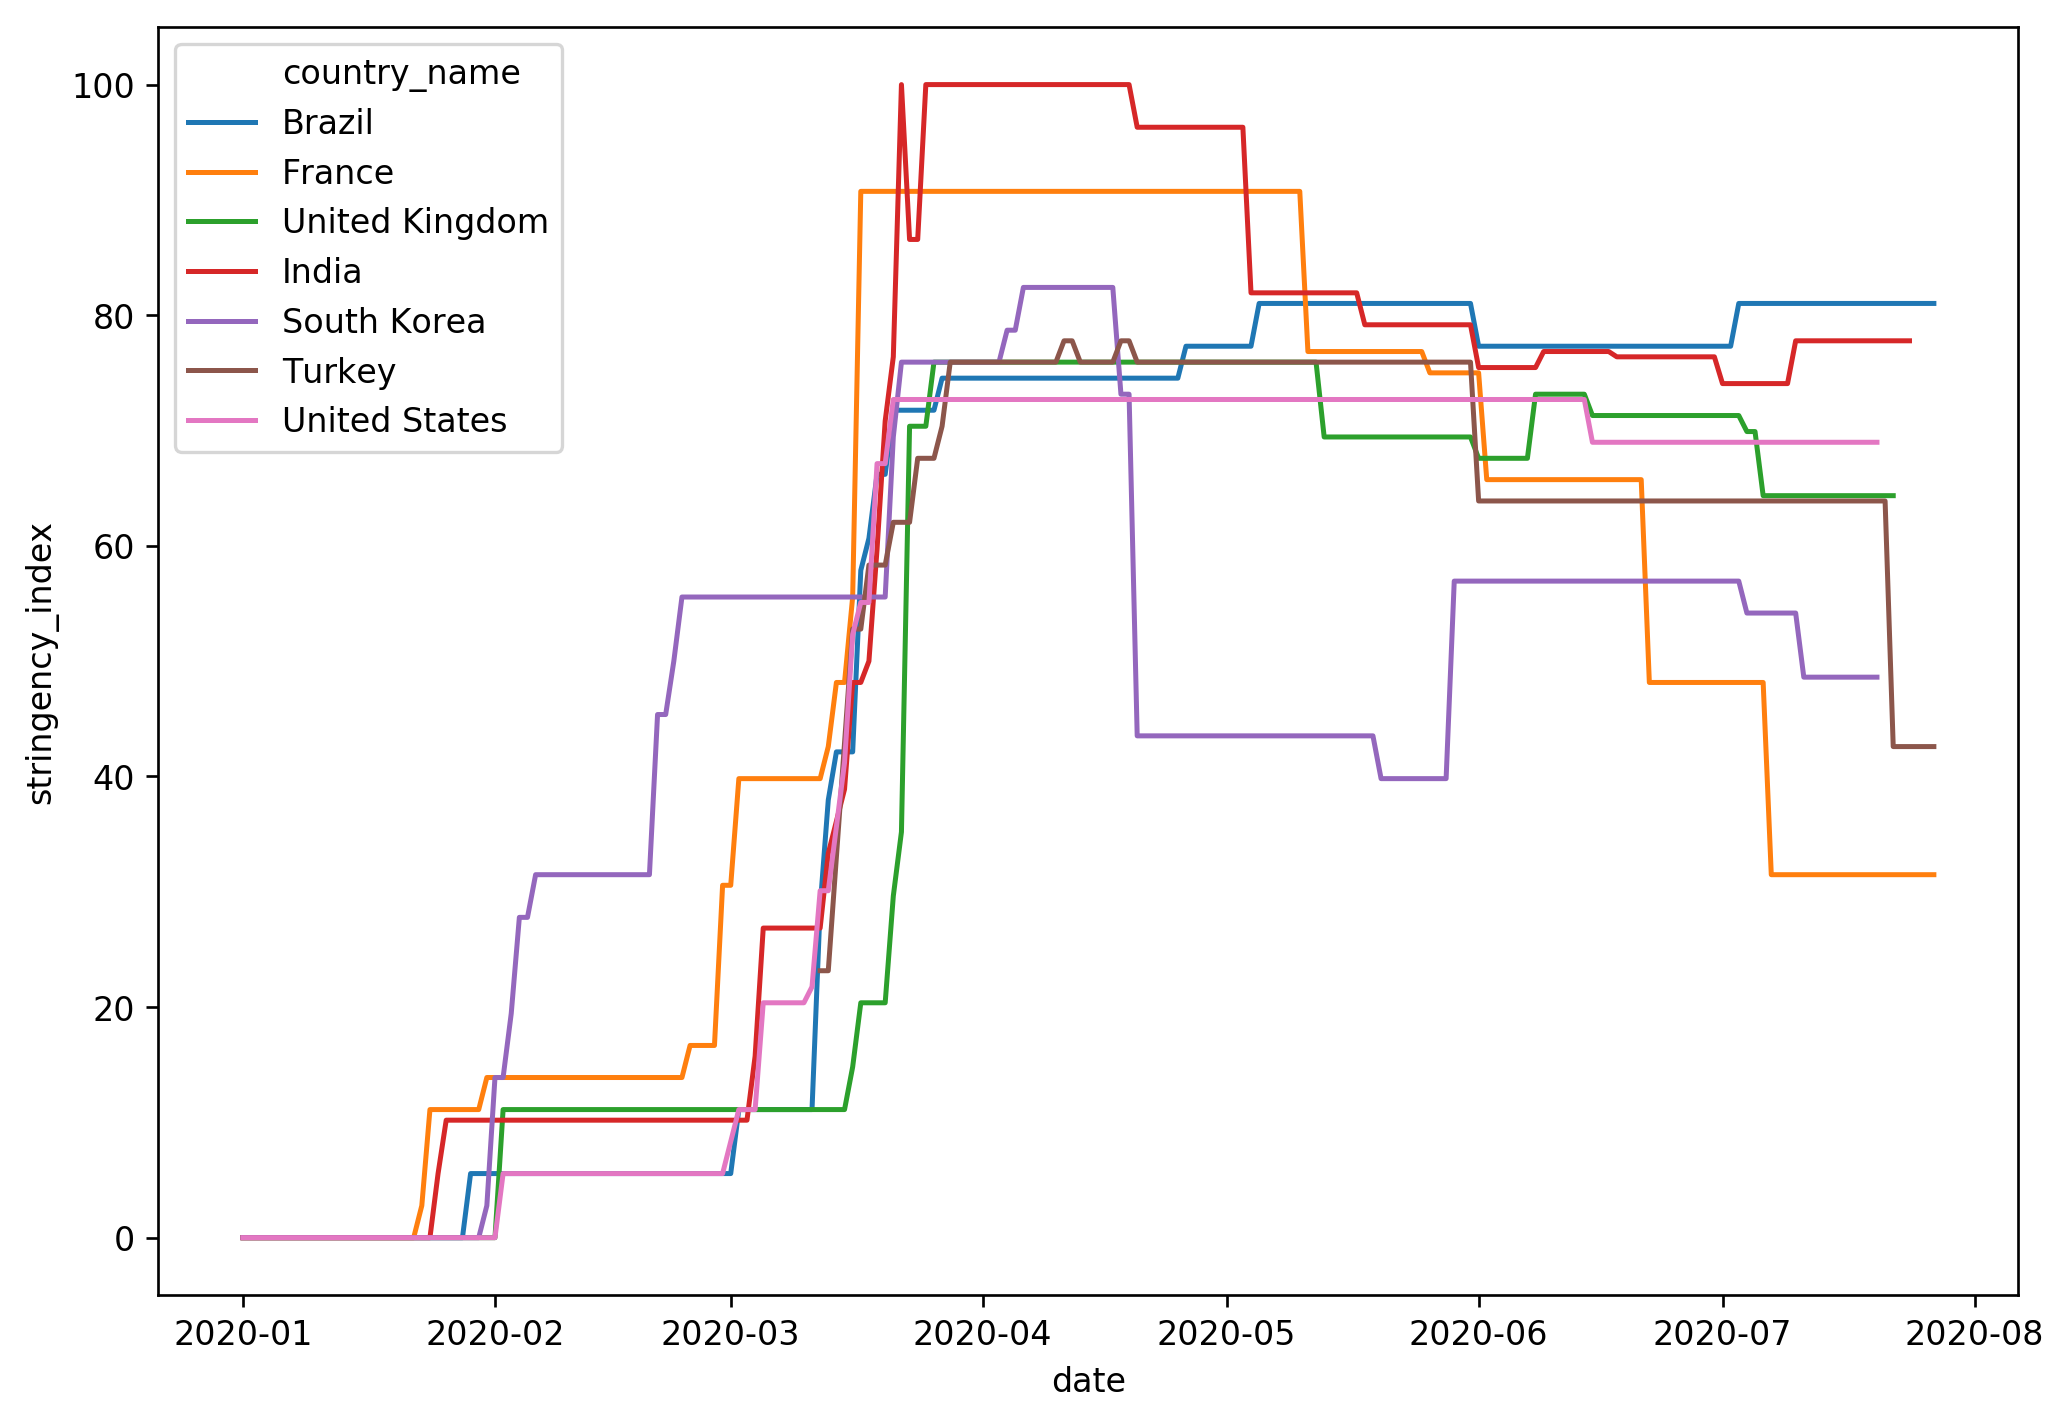

In [10]:
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120, 'font.size':10})

df = data[data.iso_code.isin(['IND','USA','GBR','FRA','KOR','TUR','BRA'])]\
[['date','iso_code','country_name','total_cases','new_cases','stringency_index']]
df['date'] = pd.to_datetime(df['date'])

sns.lineplot(x="date", y="stringency_index", hue='country_name', data=df)

## Modelling the Abstract Epidemic

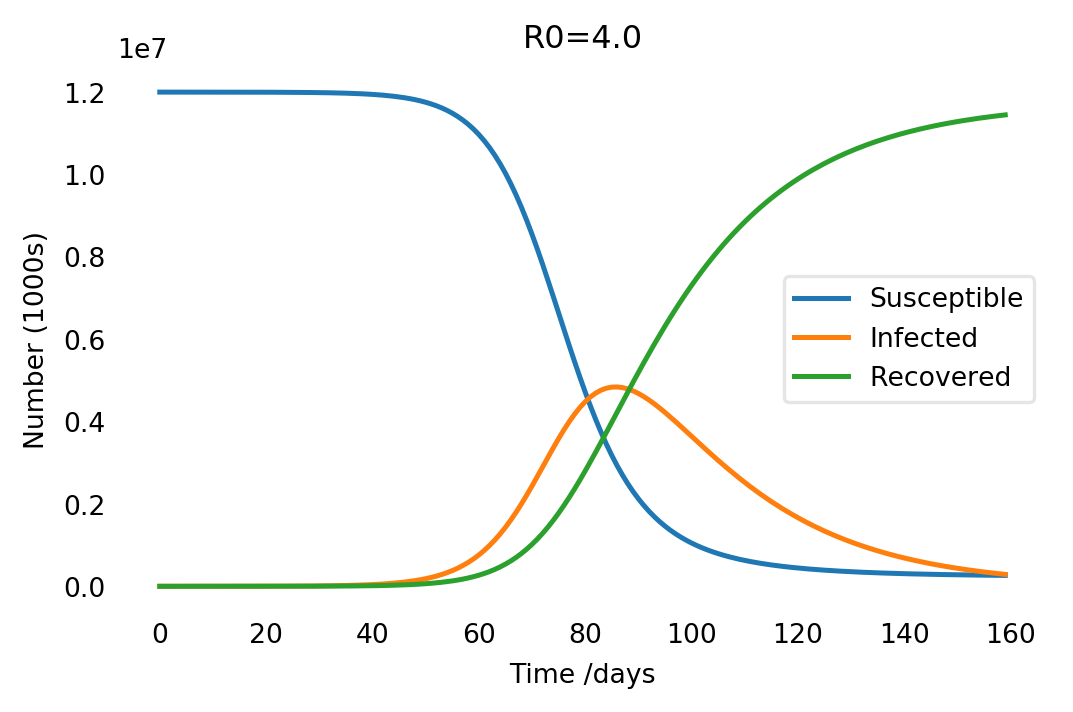

In [11]:
# REF: https://github.com/shwars/SlidingSIR/blob/master/notebooks/EpiModelling.ipynb

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Population, N.
N = 12000000

# Initial Number of infected and recovered, I0 and R0.
I0, R0 = 100, 0

# The rest (S0) are potentially susceptible
S0 = N - I0 - R0

# Transmission coefficient beta and inverse mean time to recovery gamma (in 1/day).
beta, gamma = 0.2, 1./20

# Number of days to compute:
days = 160

# computational grid
t = np.linspace(0, days, days)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# We define the initial vector (boundary conditions) and solve the equation using odeint:
    
# Initial Vector
y0 = S0, I0, R0

# Solve SIR equations on time grid t
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

plt.rcParams.update({'figure.figsize': (5, 3), 'figure.dpi': 120, 'font.size':8})

fig = plt.figure()
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(S,label='Susceptible')
ax.plot(I,label='Infected')
ax.plot(R,label='Recovered')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title('R0={}'.format(beta/gamma))
plt.show()

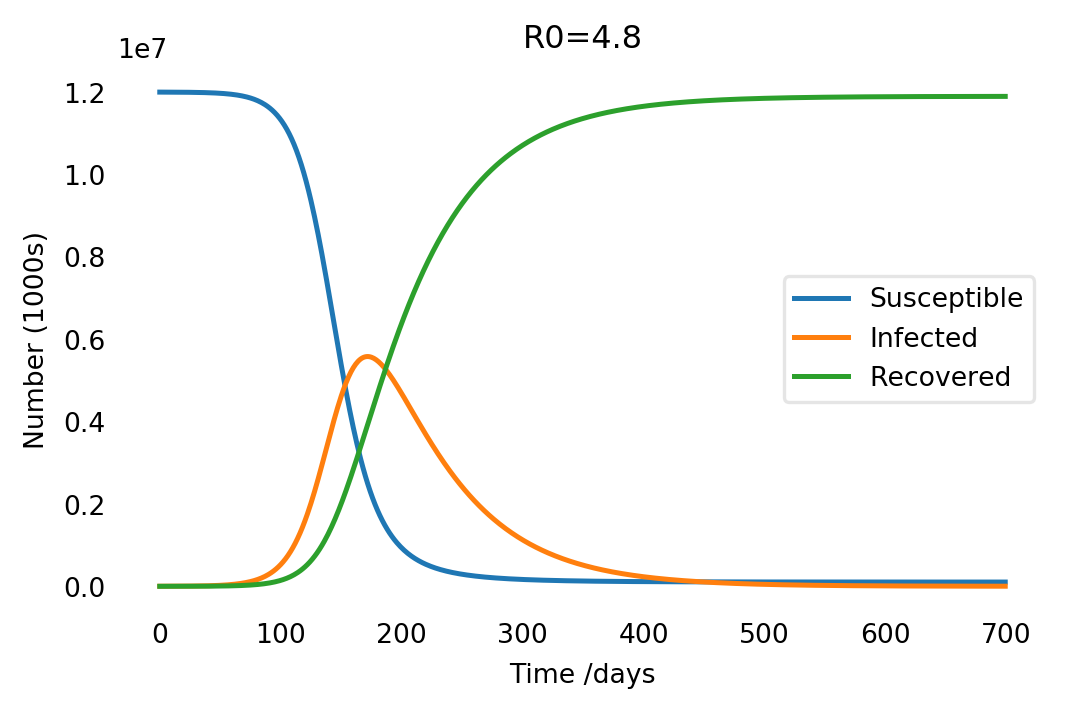

In [12]:
## Experiments

def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def experiment(N, I0, R0, beta, gamma, days):
    # computational grid
    t = np.linspace(0, days, days)
    
    # Initial suseptible population
    S0 = N - I0 - R0
    
    # Initial Vector
    y0 = S0, I0, R0

    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    
    plt.rcParams.update({'figure.figsize': (5, 3), 'figure.dpi': 120, 'font.size':8})
    
    fig = plt.figure()
    ax = fig.add_subplot(111, axisbelow=True)
    ax.plot(S,label='Susceptible')
    ax.plot(I,label='Infected')
    ax.plot(R,label='Recovered')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.title('R0={}'.format(round(beta/gamma,2)))
    plt.show()
    
experiment(12000000, 1000, 0, 0.08, 1/60, 700)

## Estimate Effective Reproduction Number (Rt)

In [13]:
from scipy.optimize import minimize


# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Compute SIR model starting from given numbers of infected/removed ppl
def sir_model(infected,removed,N,beta,gamma,ndays):
    t = np.linspace(0,ndays,ndays)
    y0 = N-infected-removed,infected,removed
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    return ret.T # S,I,R

def model(V,R,N,beta,gamma):
    S,I,R = sir_model(V[0],R[0],N,beta,gamma,len(V))
    dV = np.diff(V)
    dI = np.diff(I+R)
    return np.linalg.norm(dV-dI)

# Fix the gamma parameter
the_gamma = 1/14

def fit(V,R,N):
    res = minimize(lambda x:model(V,R,N,x,the_gamma),x0=0.5,method='powell')
    return res.x,the_gamma

def compute_params(df, population, ndays=7):
    for i in range(0, len(df)-ndays):
        V = df['infected_avg'][i:i+ndays].to_numpy()
        R = df['removed_avg'][i:i+ndays].to_numpy()
        beta,gamma = fit(V,R,population)
        df.loc[i,'beta'] = beta
        df.loc[i,'gamma'] = gamma
    df['Rt'] = df['beta']/df['gamma']
    return df

In [14]:
%%time

country_iso_code = 'IND'

df = data[(data.iso_code == country_iso_code) & (data.total_cases > 0)].copy()
population = df.population.values[0]
country_name = df.country_name.values[0]
df = df[['date','total_cases','total_deaths','total_recoveries']].rename(columns={'total_cases':'infected','total_recoveries':'recovered','total_deaths':'deaths'})
df = df.fillna(0)
df['removed'] = df['deaths'] + df['recovered']
df['date'] = pd.to_datetime(df['date'])

# smoothing
smoothing_window = 3
for x in ['infected','deaths','recovered','removed']:
    df[x + '_avg'] = df[x].rolling(window=smoothing_window).mean()
    
df = df[df['infected_avg'] > 1000].reset_index(drop=True)
df = compute_params(df, population, 7)

df['days'] = df.reset_index().index
df['new_infected'] = (df['infected'].diff()).clip(lower=0)
df = df.fillna(0)

df['infected_pct'] = df['infected']/population * 100
df['removed_pct'] = df['removed']/population * 100

CPU times: user 4.38 s, sys: 17.1 ms, total: 4.4 s
Wall time: 4.39 s


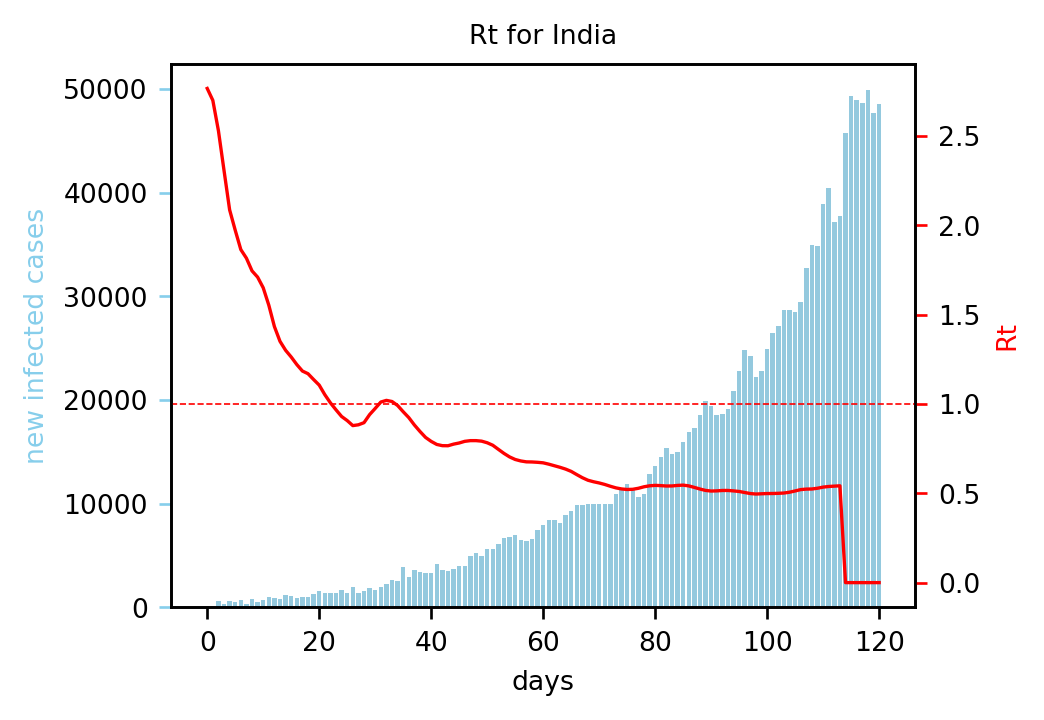

In [15]:
fig, ax1 = plt.subplots(figsize=(4,3))
# plt.suptitle('Rt for {}'.format(country_iso_code), fontsize = 8, y=1.0)

c1 = 'skyblue'
ax1.set_title('Rt for {}'.format(country_name), fontsize=8)
ax1 = sns.barplot(x='days', y='new_infected', data = df, color=c1)
ax1.set_xlabel('days')
ax1.set_ylabel('new infected cases', color=c1)
ax1.tick_params(axis='y', color=c1)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())

ax2 = ax1.twinx()
c2 = 'red'
ax2 = sns.lineplot(x='days', y='Rt', data = df, linewidth=1, color=c2)
ax2.set_ylabel('Rt', color=c2)
ax2.tick_params(axis='y', color=c2)
ax2.axhline(y=1, linewidth=0.5, ls = "--",color=c2, label="Rt=1")
plt.show()